In [3]:
# Load Libraries
import os
import glob
from torchvision.datasets.folder import default_loader
from torchvision.transforms import ToTensor, Compose
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR 
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Data preprocessing
# Data preprocessing
augment_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel
    transforms.Resize((224, 224)),                # Resize to fit VGG19 input dimensions
    transforms.ToTensor()
])

root_dir = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/'

def skipping_stride(images_dir, window_size=10, stride=1):
    images = sorted(glob.glob(os.path.join(images_dir, '*.tif')))
    sequences = []
    # if we are predicting LSTM images then should not multiply 
    for start in range(0, len(images), stride * window_size):
        window = images[start: start + stride * window_size:stride]
        sequence = [augment_transforms(default_loader(f)) for f in window]
        sequence_tensor = torch.stack(sequence, dim=0)
        sequences.append(sequence_tensor)
    return sequences

data = []

for subfolder in tqdm(sorted(os.listdir(root_dir)), desc="Processing Subfolders"):
    folder_path = os.path.join(root_dir, subfolder)
    for stride_value in [1,2]:
        sequences = skipping_stride(folder_path, stride=stride_value)
        if sequences:
            data.extend(sequences)


data_tensor = torch.stack(data, dim=0)
print(data_tensor.shape)

# Create the dataset from the tensor
dataset = TensorDataset(data_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Processing Subfolders: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:18<00:00,  1.88it/s]


torch.Size([1020, 10, 3, 224, 224])


torch.Size([1, 10, 3, 224, 224])


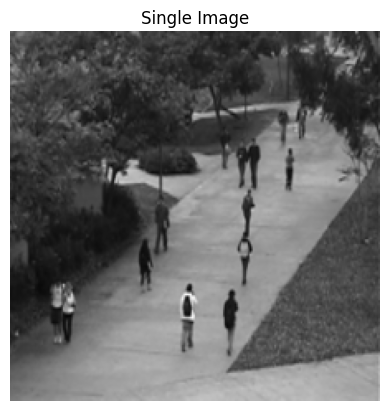

In [5]:
def plot_image_tensor(tensor_image):
    # CxHxW to HxWxC or getting invalid dimensions
    tensor_image = tensor_image.permute(1, 2, 0)  
    plt.imshow(tensor_image.numpy())
    plt.title('Single Image')
    plt.axis('off') 
    plt.show()

# Testing the dataset
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create an iterator from the DataLoader
train_loader_iter = iter(train_loader)

# Fetch the next batch
batch = next(train_loader_iter) 

print(batch[0].shape)

plot_image_tensor(batch[0][0][0])  # Plot the first image from the batch

In [8]:
import torch
import torch.nn as nn
from torchvision import models

class VGG19Autoencoder(nn.Module):
    def __init__(self):
        super(VGG19Autoencoder, self).__init__()
        # Load pre-trained VGG19 model
        vgg19_features = models.vgg19(pretrained=True).features

        # Using VGG19 as encoder (feature extractor)
        self.encoder = nn.Sequential(*list(vgg19_features.children()))

        # Decoder (upsampling the image back)
        self.decoder = nn.Sequential(
            # Assuming the output of VGG19 features is 512 channels, you can adjust as necessary
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Use sigmoid for normalizing output to [0, 1]
        )
        

    def forward(self, x):
        b, seq_len, c, h, w = x.size()
        output_sequence = []
        for t in range(seq_len):
            # Process each frame in the sequence individually
            xt = x[:, t, :, :, :]  # Shape: [batch_size, channels, height, width]
            xt = self.encoder(xt)
            xt = self.decoder(xt) 
            output_sequence.append(xt.unsqueeze(1))

        output_sequence = torch.cat(output_sequence, dim=1)
        return output_sequence

# Example usage
autoencoder = VGG19Autoencoder()
print(autoencoder)


VGG19Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=

In [7]:


batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"train_loader.dataset: {len(train_loader.dataset)}")
print(f"val_loader.dataset: {len(val_loader.dataset)}")

model = VGG19Autoencoder()  # Assuming ConvLSTM is defined elsewhere
model = nn.DataParallel(model)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, eps=1e-6, weight_decay=1e-5)

# Early stopping parameters
patience = 15
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'VGG19_AutoEncoder.pth'

# To store loss statistics
train_losses = []
val_losses = []

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    num_batches = 0
    for (images,) in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    train_losses.append(average_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}] Average Training Loss: {average_loss:.4f}')
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (images,) in val_loader:
            images = images.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, images).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Validation Loss after Epoch {epoch + 1}: {val_loss:.4f}')

    # Early stopping check and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Model saved at epoch {epoch + 1}')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch + 1}')
        break

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


train_loader.dataset: 816
val_loader.dataset: 204


Epoch 1/200:   0%|                                                                                                                                                                                               | 0/82 [00:01<?, ?batch/s]


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_16/2762842248.py", line 63, in forward
    xt = self.decoder(xt)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/batchnorm.py", line 171, in forward
    return F.batch_norm(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py", line 2478, in batch_norm
    return torch.batch_norm(
RuntimeError: running_mean should contain 512 elements not 64


In [ ]:
# Create an instance of the model
model = VGG19Autoencoder()
model = nn.DataParallel(model)
# Load the saved model parameters
model.load_state_dict(torch.load('VGG19_ConvLSTM.pth'))
model.to(device)
# Set the model to evaluation mode if you are using it for inference
model.eval()

from PIL import Image
  
files = [f"Test/Test004/{x:03d}.tif" for x in range(100,200)]

files_iter = iter(files)
 

In [ ]:

# Load one image for testing
image_path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/' + next(files_iter)
image = Image.open(image_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform =   transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale
    transforms.Resize((256, 256)),                # Resize if necessary
    transforms.ToTensor()                         # Convert to tensor
])
image = transform(image).to(device)
image = image.unsqueeze(1).unsqueeze(1)  # Add a batch dimension at the front 
image = image.permute(1,2, 0, 3, 4)  # Rearranges to [1, 3, 158, 238, 1]
print(image_path)
print(image.shape)
 
with torch.no_grad():
    output = model(image).to(device)
    print("Output shape:", output.shape)

# Convert to NumPy arrays for visualization
np_image = image.squeeze().cpu().numpy()
np_output = output.squeeze().cpu().numpy()

# If the images have channels as the first dimension, transpose them to (H, W, C)
if np_image.shape[0] in (1, 3):
    np_image = np_image.transpose(1, 2, 0)
if np_output.shape[0] in (1, 3):
    np_output = np_output.transpose(1, 2, 0)




# Calculate the absolute difference
difference = np.abs(np_image - np_output) 

# Calculate the MSE
mse = np.mean((np_image - np_output) ** 2)

print("Mean Squared Error:", mse)

# Create a heatmap to visualize the differences
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np_output, cmap='gray')
plt.title('Output Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(difference, cmap='hot')
plt.title('Difference Heatmap')
plt.axis('off')

plt.show()

